# **Environment**

In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('axes', grid=True)

import contractions
from autocorrect import Speller

import nltk
from nltk.probability import FreqDist
from nltk.util import bigrams, trigrams
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from wordcloud import WordCloud

In [2]:
root_dir = 'C:/Users/delst/OneDrive/Desktop/Code/Workspace/NLP_Disaster_Tweets'
sys.path.append(root_dir)

from A_Root_Dir.Configurations.setup_env import setup_environment
config = setup_environment(root_dir)

# File Paths
sdo_pkl = config.sdo_pkl
sdo_parq = config.sdo_parq

# Class Imports
from Modularization.corpus_bow import TextProcessor
from Modularization.corpus_bow import load_corpus_bow

fig_size = config.fig_size_m

---

# **Data Load**

In [3]:
filename = 'c1_ini_process_train.parquet'
path_to_parq_store = os.path.join(sdo_parq, filename)

df_train = pd.read_parquet(path_to_parq_store)

In [4]:
filename = 'c1_ini_process_test.parquet'
path_to_parq_store = os.path.join(sdo_parq, filename)

df_test = pd.read_parquet(path_to_parq_store)

In [5]:
display(df_train.head())
display(df_test.head())

,id,keyword,text,target
31,48,ablaze,@bbcmtd wholesale markets ablaze,1
32,49,ablaze,we always try to bring the heavy #metal #rt,0
33,50,ablaze,#africanbaze breaking newsnigeria flag set abl...,1
34,52,ablaze,crying out for more! set me ablaze,0
35,53,ablaze,on plus side look at the sky last night it was...,0


,id,keyword,text
15,46,ablaze,birmingham wholesale market is ablaze bbc news...
16,47,ablaze,@sunkxssedharry will you wear shorts for race ...
17,51,ablaze,#previouslyondoyintv toke makinwaûªs marriage ...
18,58,ablaze,check these out #nsfw
19,60,ablaze,psa iûªm splitting my personalities?? techies ...


In [6]:
corpus_doc_1, corpus_word_1, bow_1, bow_fd_1 = load_corpus_bow('1')
corpus_doc_0, corpus_word_0, bow_0, bow_fd_0 = load_corpus_bow('0')
corpus_word_sw, bow_sw, bow_fd_sw = load_corpus_bow('sw')

In [7]:
df = df_train

---

In [8]:
list(df.text)

['@bbcmtd wholesale markets ablaze',
 'we always try to bring the heavy #metal #rt',
 '#africanbaze breaking newsnigeria flag set ablaze in aba',
 'crying out for more! set me ablaze',
 'on plus side look at the sky last night it was ablaze',
 '@phdsquares #mufc theyve built so much hype around new acquisitions but i doubt they will set the epl ablaze this season',
 'inec office in abia set ablaze ',
 'barbados #bridgetown jamaica ûò two cars set ablaze santa cruz ûó head of the st elizabeth police superintende',
 'ablaze for you lord d',
 'check these out    #nsfw',
 'on the outside youre ablaze and alivebut youre dead inside',
 'had an awesome time visiting the cfc head office the ancop site and ablaze thanks to tita vida for taking care of us ??',
 'soooo pumped for ablaze ???? @southridgelife',
 'i wanted to set chicago ablaze with my preaching but not my hotel!',
 'i gained 3 followers in the last week you? know your stats and grow with',
 'how the west was burned thousands of wil

In [9]:
print(df.text[57])
df.loc[57]

set our hearts ablaze and every city was a gift and every skyline was like a kiss upon the lips @û_ httpstcocyompz1a0z


id                                                        81
keyword                                               ablaze
text       set our hearts ablaze and every city was a gif...
target                                                     0
Name: 57, dtype: object

---

In [10]:
def visualize_top_n_keywords(df, top_n, fig_size):
    df['target_mean'] = df.groupby('keyword')['target'].transform('mean')
    dfs = df.sort_values(by='target_mean', ascending=False)
    
    top_keywords = dfs['keyword'].value_counts().index[:top_n]
    dfs = dfs[dfs['keyword'].isin(top_keywords)]
    
    fig = plt.figure(figsize=fig_size, dpi=100)
    ax = sns.countplot(y=dfs['keyword'], hue=dfs['target'])
    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=8)
    plt.legend(loc=1)
    plt.title('Target Distribution in Top {} Keywords'.format(top_n))
    
    plt.show()
    
    df.drop(columns=['target_mean'], inplace=True)
    
def visualize_all_keywords(df, top_n, fig_size):
    df['target_mean'] = df.groupby('keyword')['target'].transform('mean')
    dfs = df.sort_values(by='target_mean', ascending=False)
    
    top_keywords = dfs['keyword'].value_counts().index[:top_n]
    dfs = dfs[dfs['keyword'].isin(top_keywords)]
    
    fig = plt.figure(figsize=fig_size, dpi=100)
    ax = sns.countplot(x=dfs['keyword'], hue=dfs['target'])
    
    plt.tick_params(axis='y', labelsize=15)
    ax.set(xticklabels=[])
    plt.legend(loc=1)
    plt.title('Target Distribution in Top {} Keywords'.format(top_n))
    
    plt.show()
    
    df.drop(columns=['target_mean'], inplace=True)

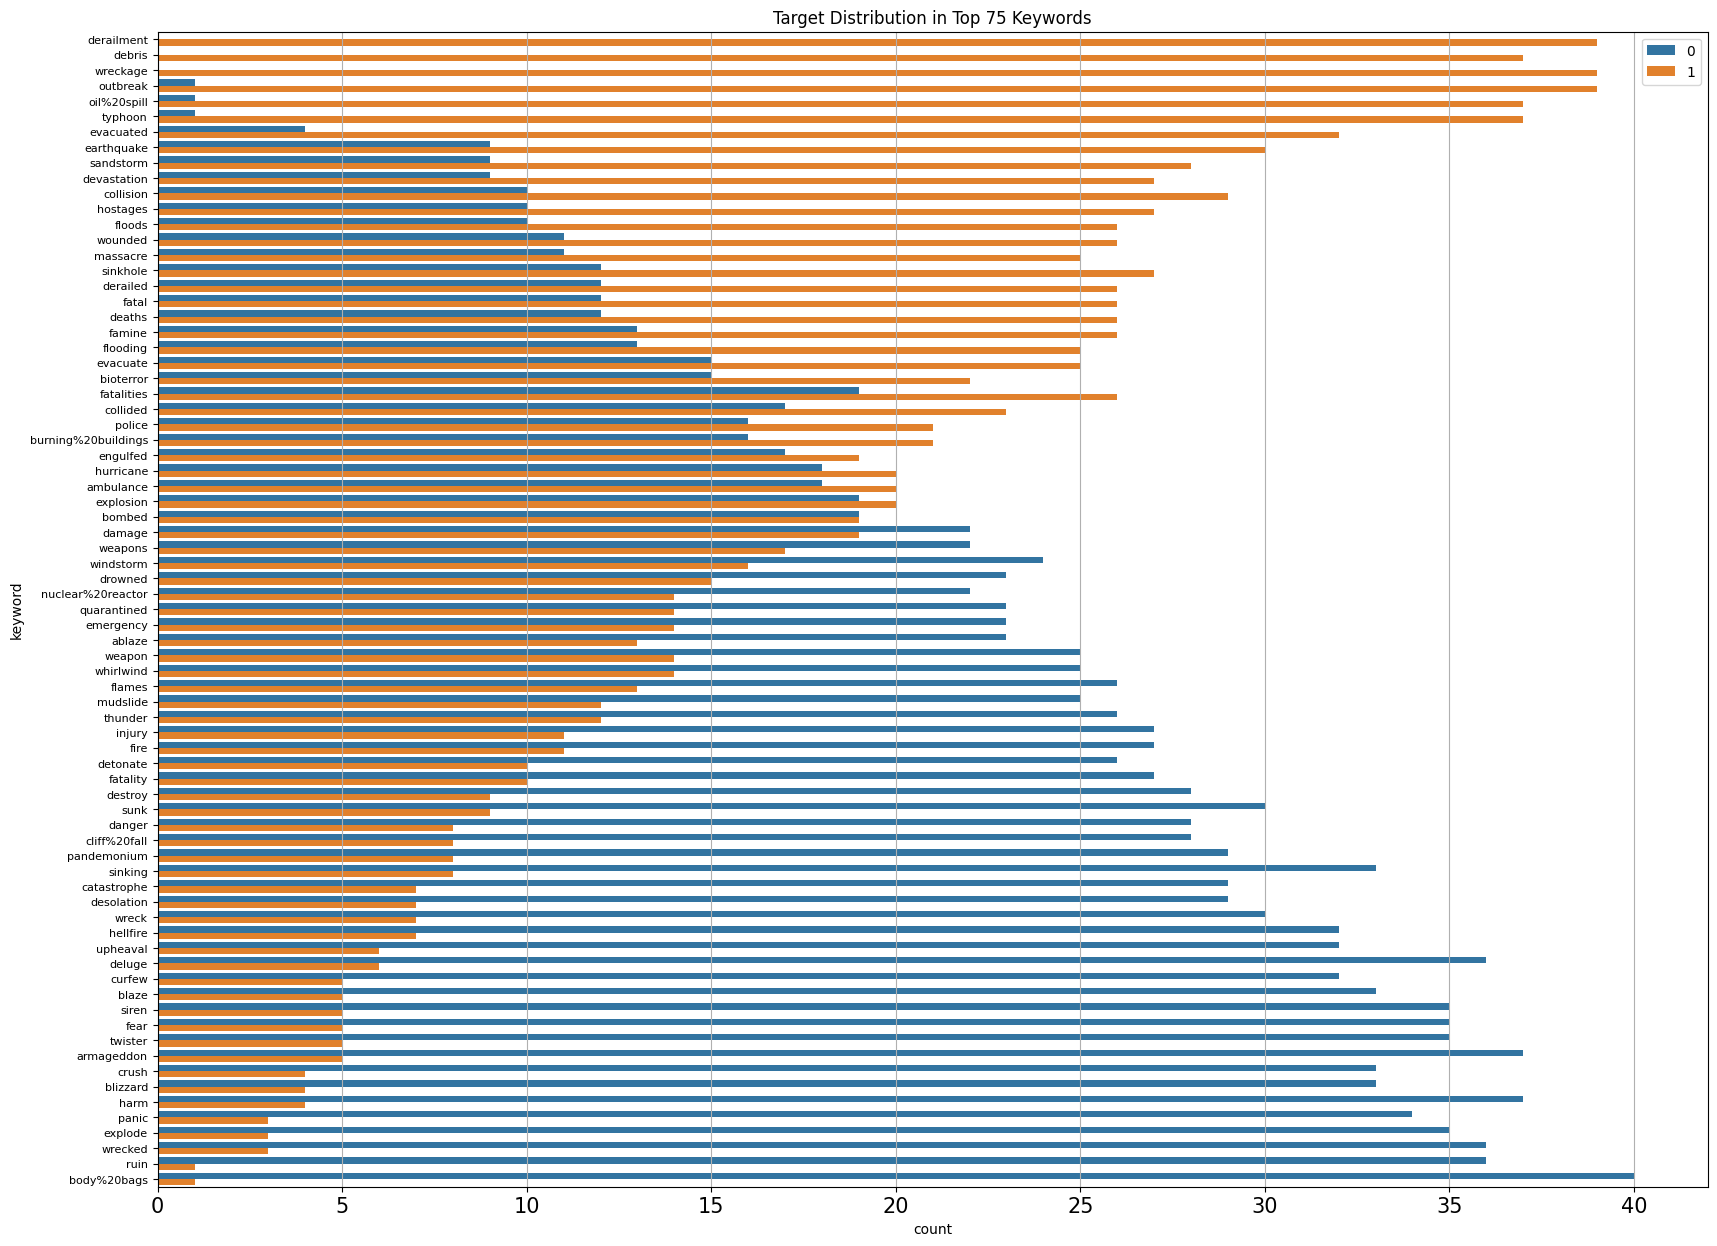

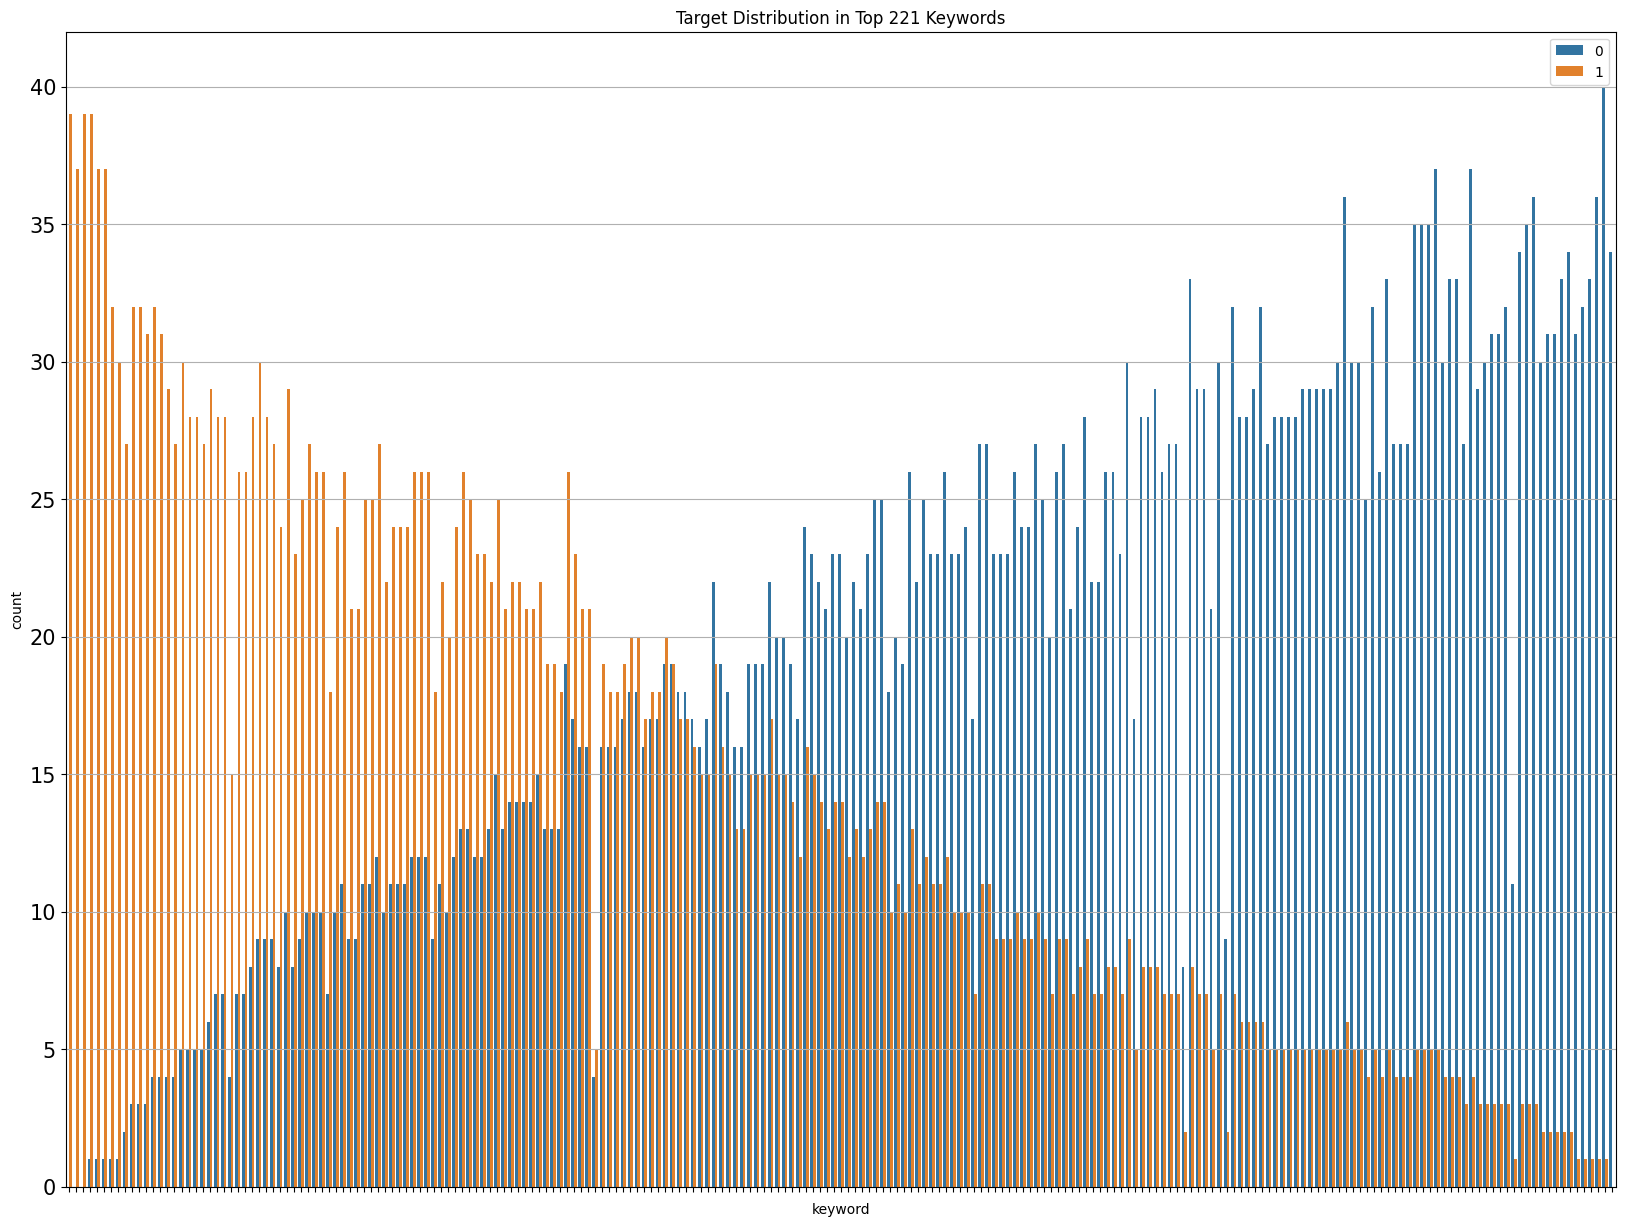

In [11]:
top_100 = visualize_top_n_keywords(df, 75, fig_size)
model_conf = visualize_all_keywords(df, 221, fig_size)

---

In [12]:
def show_wordcloud(data, title, ax):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop_words,
        max_words=100,
        max_font_size=60,
        scale=3,
        random_state=1,
        collocations=False
    ).generate(str(data))

    ax.axis('off')
    ax.imshow(wordcloud)
    ax.set_title(title)

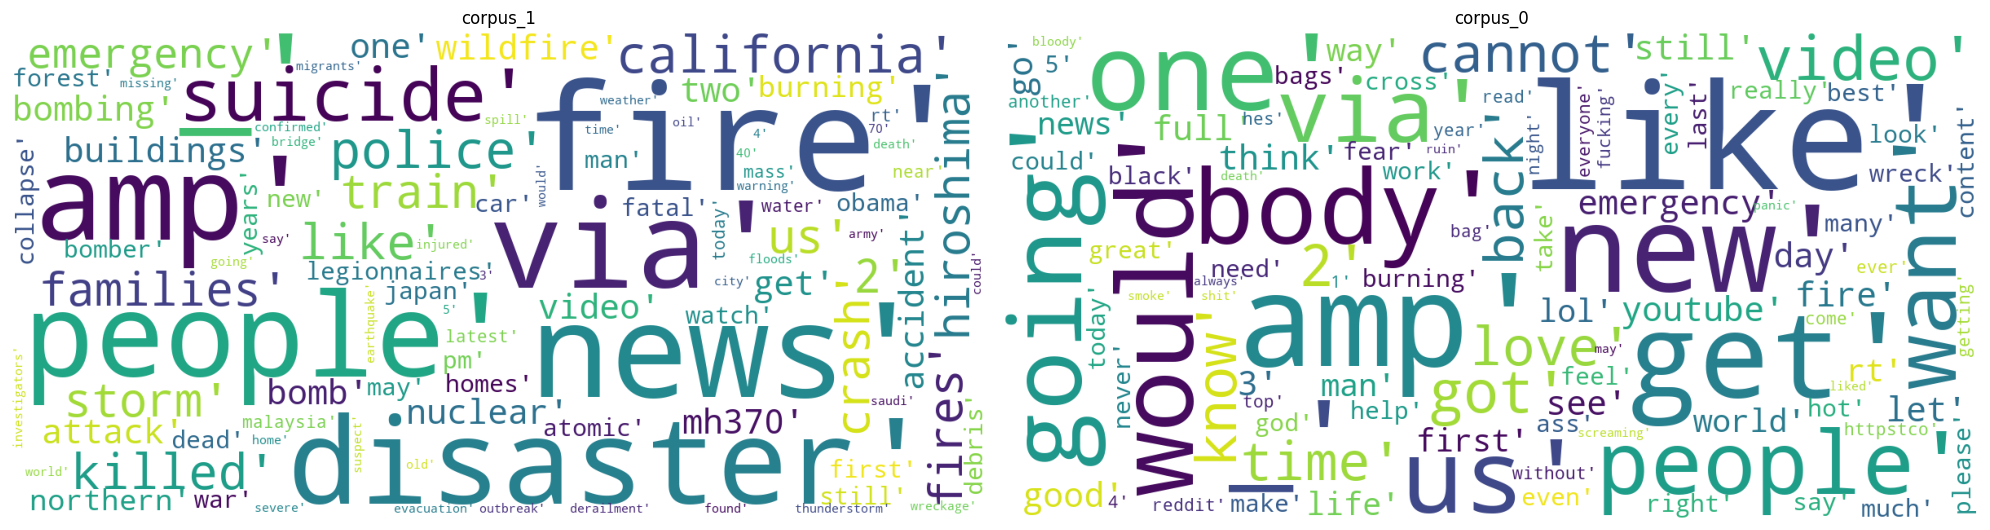

In [13]:
fig, ax = plt.subplots(1, 2, figsize=fig_size)

show_wordcloud(corpus_word_1, 'corpus_1', ax[0])
show_wordcloud(corpus_word_0, 'corpus_0', ax[1])

plt.tight_layout()
plt.show()

In [14]:
# get all the occurences of 'word' from a list of lists
def get_occurences(corpus, word):
    occurences = 0
    for tweet in corpus:
        occurences += tweet.count(word)
    return occurences
get_occurences(corpus_word_0, "body")

133

---

In [15]:
# a function to remove single characters/lists of tokens from a tokenized list
def remove_single_char(token_lists):
    return [[token for token in tokens if len(token) > 1] for tokens in token_lists]

corpus_ngram_1 = remove_single_char(corpus_doc_1)
corpus_ngram_0 = remove_single_char(corpus_doc_0)

In [16]:
def exclude_words(token_lists, ngram_drop_words):
    return [[token for token in tokens if token not in ngram_drop_words] for tokens in token_lists]

ngram_drop_words = ['liked', '@youtube'],['content','policy'],['ebay']
ngram_drop_words = [word for sublist in ngram_drop_words for word in sublist]

corpus_ngram_1 = exclude_words(corpus_ngram_1, ngram_drop_words)
corpus_ngram_0 = exclude_words(corpus_ngram_0, ngram_drop_words)

In [17]:
def generate_bigrams(text_list):
    bigrams_list = [list(bigrams(tokens)) for tokens in text_list]
    return bigrams_list

def generate_trigrams(text_list):
    trigrams_list = [list(trigrams(tokens)) for tokens in text_list]
    return trigrams_list

In [18]:
corpus_bigrams_1 = sum(generate_bigrams(corpus_ngram_1),[])
corpus_trigrams_1 = sum(generate_trigrams(corpus_ngram_1),[])

corpus_bigrams_0 = sum(generate_bigrams(corpus_ngram_0),[])
corpus_trigrams_0 = sum(generate_trigrams(corpus_ngram_0),[])

In [19]:
fd_bigrams_1 = FreqDist(corpus_bigrams_1)
fd_trigrams_1 = FreqDist(corpus_trigrams_1)

fd_bigrams_0 = FreqDist(corpus_bigrams_0)
fd_trigrams_0 = FreqDist(corpus_trigrams_0)

In [20]:
print("Most common bigrams:", fd_bigrams_1.most_common(10))
print("Most common trigrams:", fd_trigrams_1.most_common(10))

Most common bigrams: [(('suicide', 'bomber'), 56), (('northern', 'california'), 40), (('oil', 'spill'), 37), (('suicide', 'bombing'), 33), (('burning', 'buildings'), 33), (('california', 'wildfire'), 31), (('70', 'years'), 30), (('confirmed', 'mh370'), 29), (('homes', 'razed'), 28), (('bomber', 'detonated'), 28)]
Most common trigrams: [(('northern', 'california', 'wildfire'), 28), (('suicide', 'bomber', 'detonated'), 28), (('latest', 'homes', 'razed'), 27), (('homes', 'razed', 'northern'), 27), (('pkk', 'suicide', 'bomber'), 27), (('bomber', 'detonated', 'bomb'), 27), (('families', 'sue', 'legionnaires'), 26), (('40', 'families', 'affected'), 26), (('families', 'affected', 'fatal'), 26), (('affected', 'fatal', 'outbreak'), 26)]


In [21]:
def plot_ngrams(fd_ngrams, title, ax, n):
    ngrams = fd_ngrams.most_common(n)
    ngrams, frequencies = zip(*ngrams)
    ngrams = [' '.join(gram) for gram in ngrams]

    ax.barh(ngrams[::-1], frequencies[::-1])
    ax.set_title(title)
    ax.tick_params(axis='y', rotation=45)

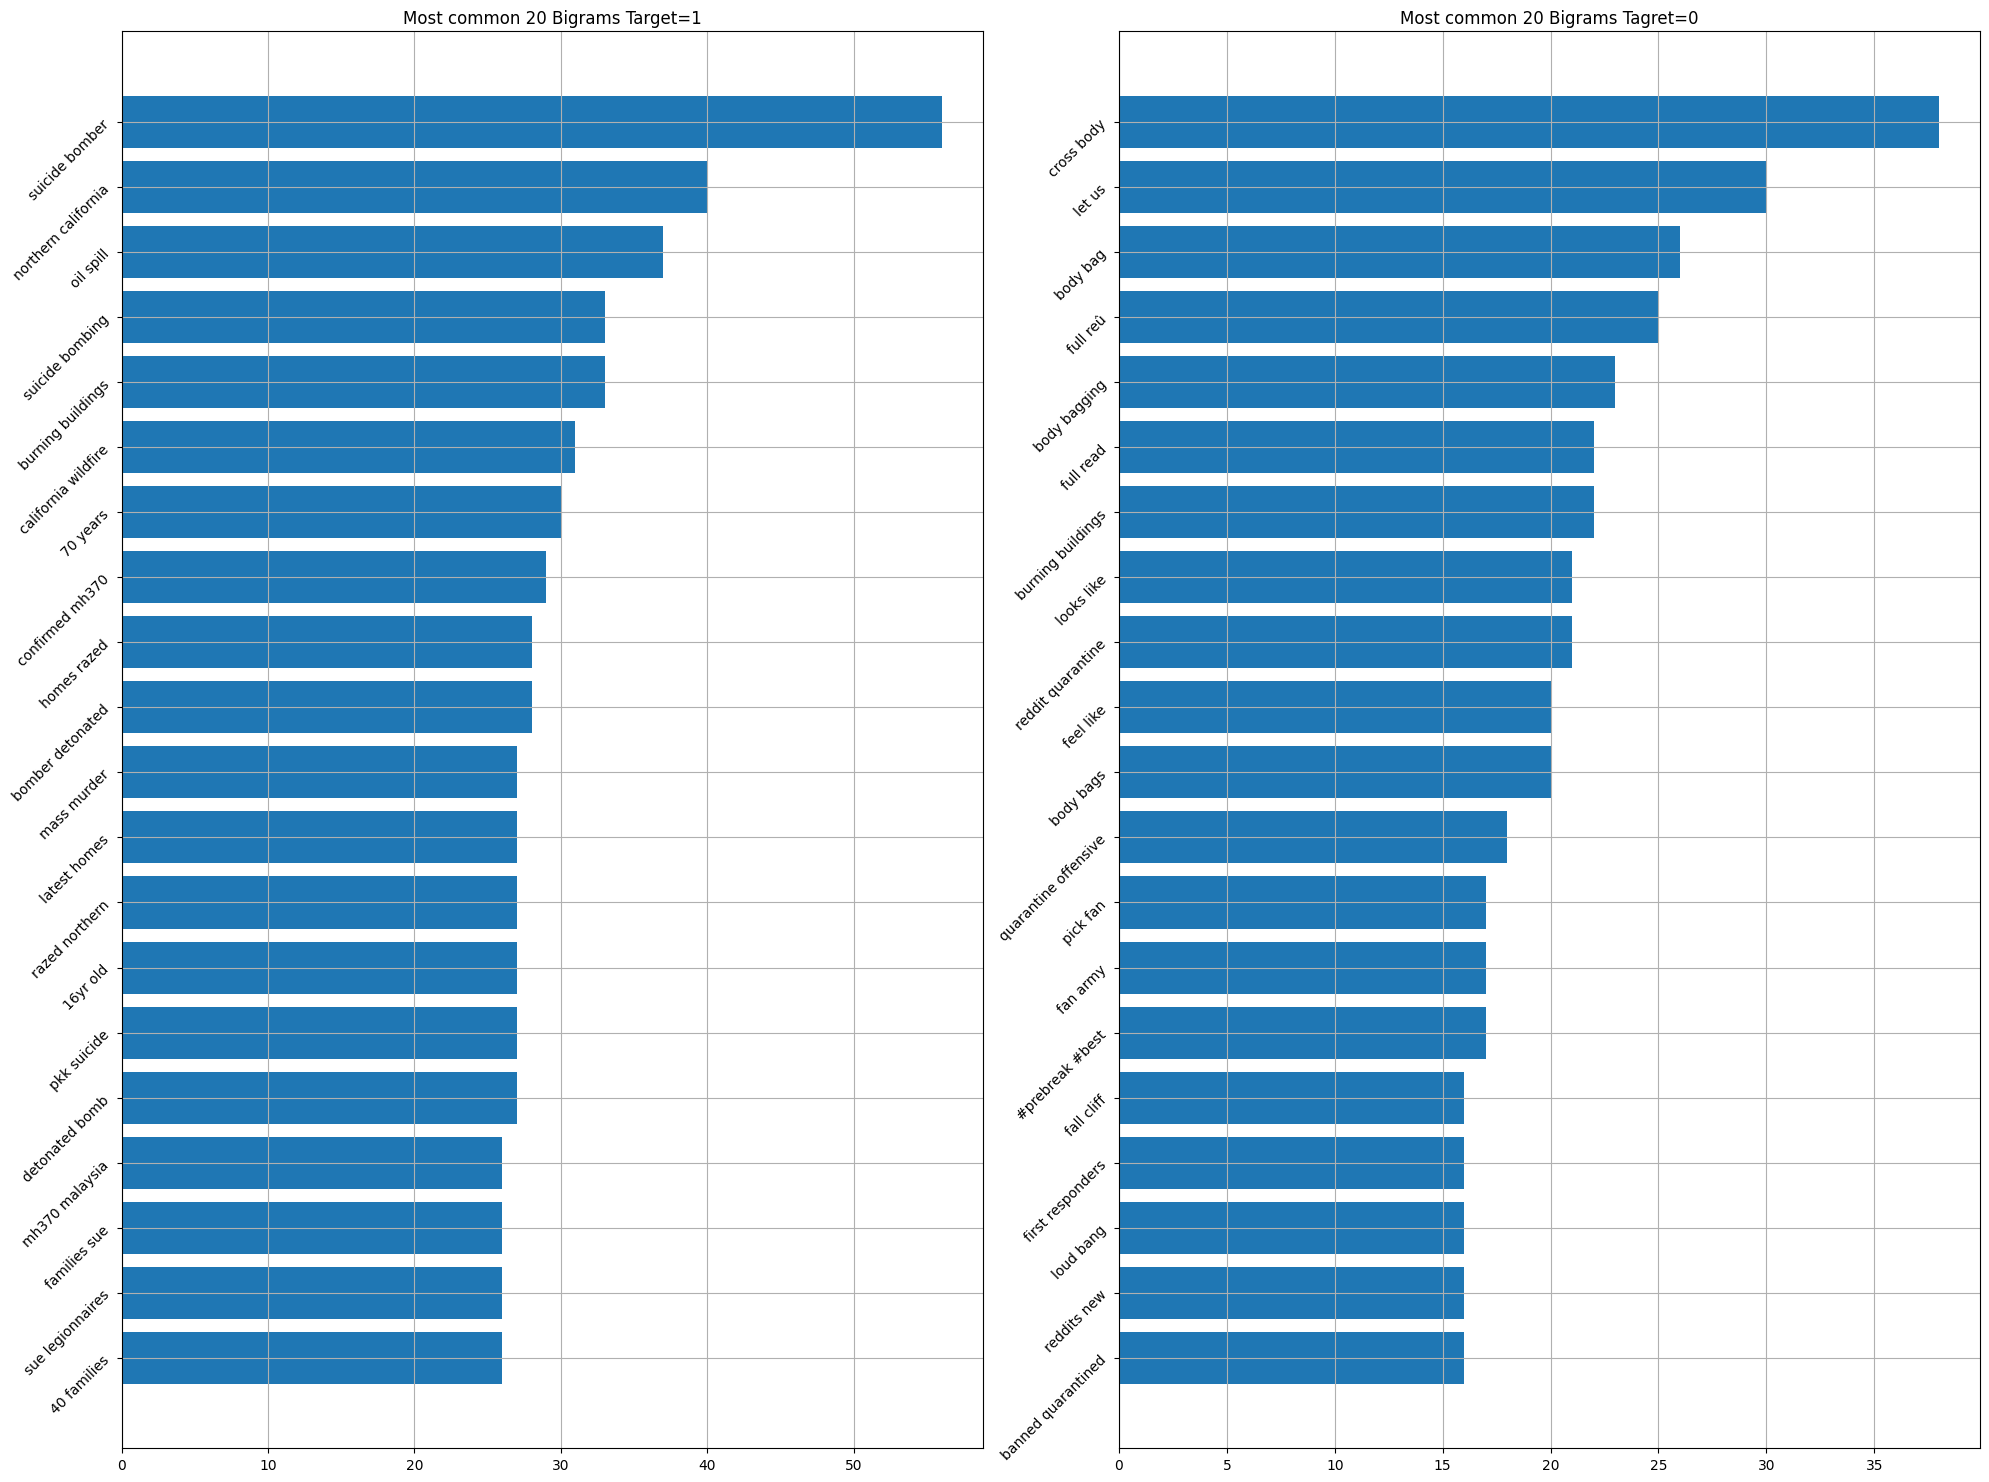

In [22]:
fig, ax = plt.subplots(1, 2, figsize=fig_size)

plot_ngrams(fd_bigrams_1, "Most common 20 Bigrams Target=1", ax[0], 20)
plot_ngrams(fd_bigrams_0, "Most common 20 Bigrams Tagret=0", ax[1], 20)

plt.tight_layout()
plt.show()

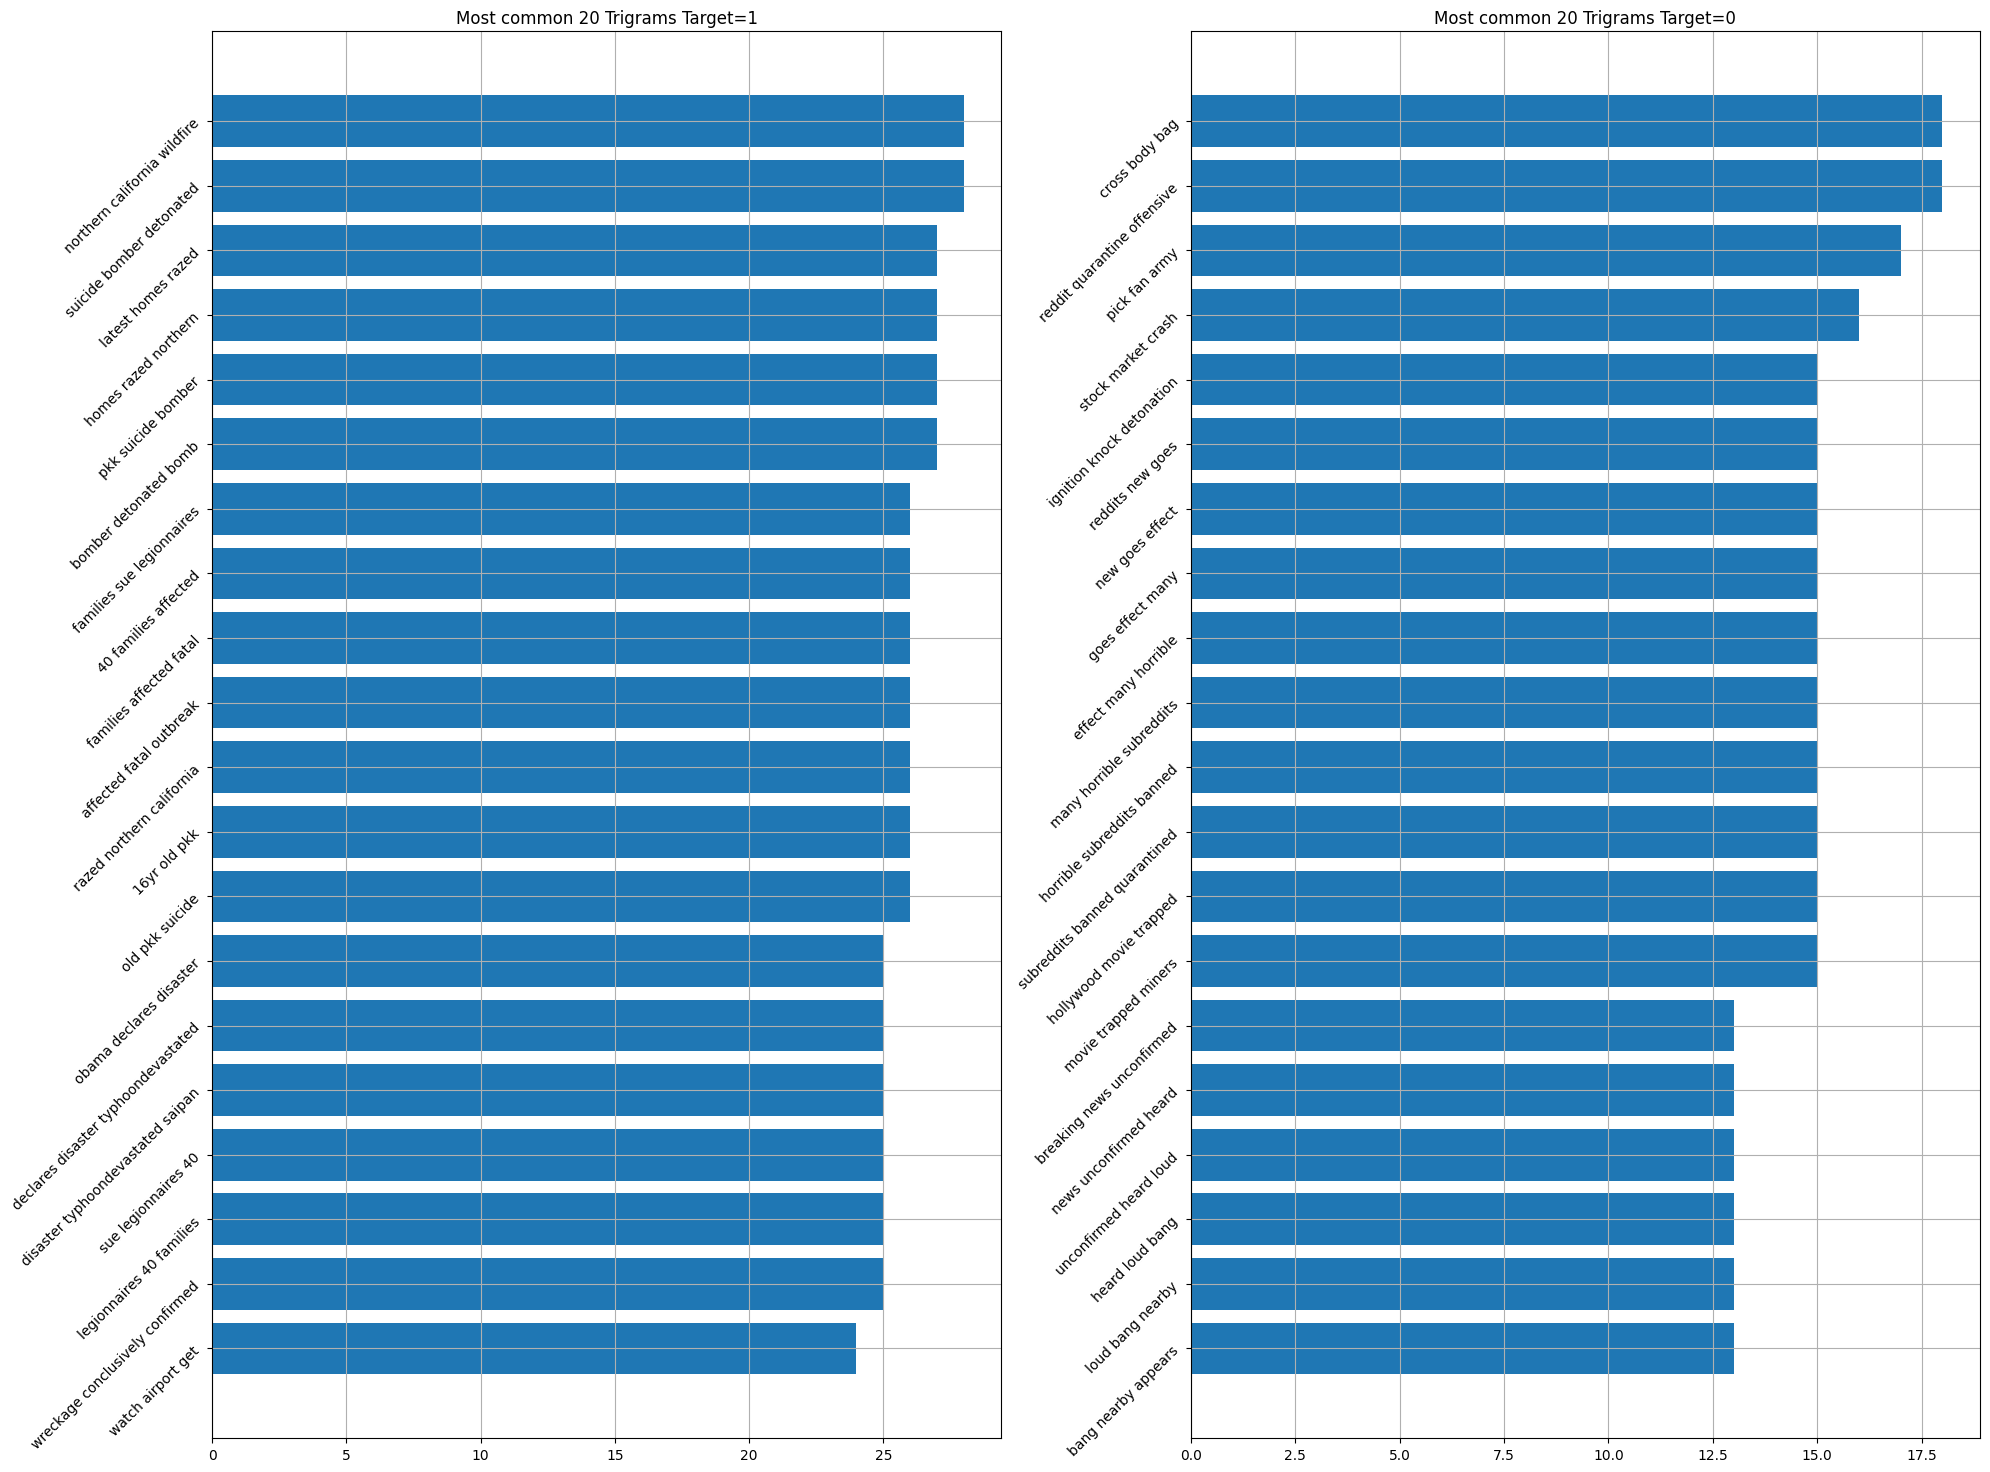

In [23]:
fig, ax = plt.subplots(1, 2, figsize=fig_size)

plot_ngrams(fd_trigrams_1, "Most common 20 Trigrams Target=1", ax[0], 20)
plot_ngrams(fd_trigrams_0, "Most common 20 Trigrams Target=0", ax[1], 20)

plt.tight_layout()
plt.show()